# Aplicação de Modelos de Machine Learning

Este caderno é destinado a criação de modelos de aprendizado de máquina (regressão, classificação e agrupamento), envolvendo etapas de comparação, avaliação e validação de modelos com o intuito de predizer os dados e geração de insights. O caderno está dividido nas seguintes etapas:

* 1. **Leitura dos dados**: Importação das bibliotecas python e dados necessários.
* 2. **Transformação dos dados**: Preparação dos dados para o modelo, envolvendo etapas com normalização, codificação de variáveis categóricas, dentre outras.
* 3. **Modelos de Regressão**: Diferentes modelos de regressão (LinearRegressiom, KNeighborsRegressor, DummyRegressor) são treinados, avaliados e usados para fazer predição de dados. São calculados métricas como MAE, MDE e R².
* 4. **Modelos de Classificação**: Diferentes modelos de Classificação (LogisticRegression, KNeighborsClassifier) são treinados, avaliados e udados para fazer predição. São calculados métricas como precisão, recall, F1-score.
* 5. **Modelo de Agrupamento**: Uso do K-Médias para agrupar os dados ao seu grupo mais próximo e identificação do perfil dos dados. Uso do método do cotovelo, centróides e estudo de clusters.
* 6. **Insights**: Resumo dos insights gerados durante o desenvolvimento dos modelos e sugestão de melhorias.

## 1. Leitura dos dados

* Bibliotecas:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split,  ShuffleSplit, KFold, cross_validate
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
import pickle
import os

* Dados:

In [2]:
dados = pd.read_csv('../data/teste_atualizado_ML.csv')

In [3]:
dados_dicionario = pd.read_csv('../data/dicionario_ML.csv')

In [5]:
dados.head()

,nome,host_name,bairro_group,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Outros,Outros,Manhattan,Private room,110,3,47,0.57,1,248
1,Outros,Outros,Brooklyn,Private room,40,1,1,1.00,2,151
2,Outros,Outros,Brooklyn,Private room,57,3,33,0.85,3,345
3,Outros,Outros,Brooklyn,Entire home/apt,375,2,14,0.60,1,75
4,Outros,Outros,Queens,Private room,195,4,0,0.72,1,0


In [6]:
dados_dicionario.head()

,variavel,descricao,tipo,subtipo
0,nome,Título do anúncio,qualitativa,nominal
1,host_name,nome do anfitrião,qualitativa,nominal
2,bairro_group,grupo ou região do bairro onde o imóvel está l...,qualitativa,nominal
3,room_type,Tipo de acomodação,qualitativa,nominal
4,price,Preço por noite em dólares,quantitativa,contínua


In [4]:
paleta_personalizada = ["#E01168", "#F877AD", "#E995B8", "#510524","#D0B2BE","#8C0038"]

## 2. Transformação dos dados

* Estruturação das variáveis:

In [5]:
target_variable = 'price'

useless_variables = (
    dados_dicionario.query("tipo == 'inútil'").variavel.to_list()
)

nominal_variables = (
    dados_dicionario.query("subtipo == 'nominal' and variavel != @target_variable").variavel.to_list()
)

continuous_variables = (
    dados_dicionario.query("subtipo == 'contínua' and variavel != @target_variable").variavel.to_list()
)

discrete_variables = (
    dados_dicionario.query("subtipo == 'discreta' and variavel != @target_variable").variavel.to_list()
)

In [6]:
print("Variáveis Nominais:", nominal_variables)
print("Variáveis Contínuas:", continuous_variables)
print("Variáveis Discretas:", discrete_variables)


Variáveis Nominais: ['nome', 'host_name', 'bairro_group', 'room_type']
Variáveis Contínuas: ['reviews_por_mes']
Variáveis Discretas: ['minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count', 'disponibilidade_365']


* Separando X (Variáveis Explicativas) e Y (Variável-alvo)

In [7]:
X = dados.drop(columns=[target_variable] + useless_variables)
y = dados[target_variable]

In [36]:
print("\nX (features):\n", X)


X (features):
          nome host_name bairro_group        room_type  minimo_noites  \
0      Outros    Outros    Manhattan     Private room              3   
1      Outros    Outros     Brooklyn     Private room              1   
2      Outros    Outros     Brooklyn     Private room              3   
3      Outros    Outros     Brooklyn  Entire home/apt              2   
4      Outros    Outros       Queens     Private room              4   
...       ...       ...          ...              ...            ...   
24442  Outros    Outros    Manhattan  Entire home/apt              3   
24443  Outros    Outros    Manhattan  Entire home/apt              2   
24444  Outros    Outros     Brooklyn     Private room              3   
24445  Outros    Outros    Manhattan  Entire home/apt              1   
24446  Outros    Outros     Brooklyn  Entire home/apt              7   

       numero_de_reviews  reviews_por_mes  calculado_host_listings_count  \
0                     47             0.57  

In [37]:
print("\ny (target):\n", y)


y (target):
 0        110
1         40
2         57
3        375
4        195
        ... 
24442    226
24443    129
24444     90
24445    175
24446    200
Name: price, Length: 24447, dtype: int64


O código acima organiza e prepara os dados de forma sistemática para análise ou modelagem. Ele facilita a aplicação de diferentes técnicas a cada tipo de variável, como codificação (para nominais) ou normalização (para contínuas)

* Pipeline de Pré-Processamento:

In [8]:
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),
    ("encoding", OneHotEncoder(sparse_output=True, handle_unknown='ignore')),
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),
    ("normalization", StandardScaler()),
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),
    ("normalization", StandardScaler()),
])


 O código acima organiza pipelines para pré-processar variáveis diferentes (nominais, contínuas e discretas). Acima no nominal substitui valores faltantes pela moda e codifica em one-hot (variaveis binárias), as variaveis contínuas substituem pela média, aplicando normalização (média=0, desvio padrão=1), enquanto as variáveis discretas susbtituem valores faltantes pelos vizinhos mais próximos e aplica normalização.

* Aplicando o Pipeline:

In [9]:
nominal_features = ['nome', 'host_name', 'bairro_group', 'room_type']
continuous_features = ['reviews_por_mes']
discrete_features = ['minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count', 'disponibilidade_365']

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_preprocessor, nominal_features),
        ('continuous', continuous_preprocessor, continuous_features),
        ('discrete', discrete_preprocessor, discrete_features),
    ], sparse_threshold=1.0
)

 As variáveis nominais, contínuas e discretas são extraídas do dicionário de dados com base no subtipo. Isso assegura que cada tipo de dado seja tratado com o pipeline apropriado.

* Aplicando Preprocessor:

In [11]:
X_preprocessed = preprocessor.fit_transform(X)

In [43]:
print("Dados pré-processados:")
print(X_preprocessed)

Dados pré-processados:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 220023 stored elements and shape (24447, 15)>
  Coords	Values
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 4)	1.0
  (0, 8)	1.0
  (0, 10)	-0.44090909078971907
  (0, 11)	-0.20196365936988625
  (0, 12)	0.5290908677766379
  (0, 13)	-0.18791249140538938
  (0, 14)	1.0228838500950435
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (1, 8)	1.0
  (1, 10)	-0.15777994017854818
  (1, 11)	-0.30291967913444945
  (1, 12)	-0.49536979599046427
  (1, 13)	-0.15793502605651955
  (1, 14)	0.28675879027106943
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (2, 8)	1.0
  (2, 10)	-0.2565459229498869
  (2, 11)	-0.20196365936988625
  (2, 12)	0.2172984918475199
  :	:
  (24444, 3)	1.0
  (24444, 8)	1.0
  (24444, 10)	2.179681652076467
  (24444, 11)	-0.20196365936988625
  (24444, 12)	-0.29493184003603123
  (24444, 13)	-0.18791249140538938
  (24444, 14)	-0.27482115227505505
  (24445, 0)	1.0
  (24445, 1)	1.0
  (24445, 4)	1.0
  (24445, 7)	1.0
  (24445, 10)	-0.15777

 Acima Treina o pipeline no dataset (fit) e transforma os dados (transform).

## 3. Modelos de Regressão

### Avaliação dos Modelos

In [12]:
modelos =  [DummyRegressor(strategy='mean'), LinearRegression(), KNeighborsRegressor(n_neighbors=5)]

In [13]:
metricas = ['neg_mean_absolute_error','neg_mean_squared_error','neg_mean_absolute_percentage_error','r2']

In [14]:
monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [15]:
results_total = None
for model in modelos:
    model_name = model.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metricas, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['model'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: DummyRegressor
rodando para o modelo: LinearRegression
rodando para o modelo: KNeighborsRegressor


In [48]:
results_total.groupby('model').agg(['mean', 'std']).T

model                                         DummyRegressor  \
fit_time                                mean    5.940974e-02   
                                        std     2.447231e-02   
score_time                              mean    2.606153e-02   
                                        std     1.039841e-02   
test_neg_mean_absolute_error            mean   -9.343058e+01   
                                        std     2.874645e+00   
test_neg_mean_squared_error             mean   -6.400150e+04   
                                        std     2.254130e+04   
test_neg_mean_absolute_percentage_error mean   -7.021470e+13   
                                        std     9.947367e+13   
test_r2                                 mean   -3.477875e-04   
                                        std     3.220057e-04   

model                                         KNeighborsRegressor  \
fit_time                                mean         5.921669e-02   
                                        std          1.143646e-02   
score_time                              mean         5.037332e+00   
                                        std          3.545123e-01   
test_neg_mean_absolute_error            mean        -7.740004e+01   
                                        std          3.531553e+00   
test_neg_mean_squared_error             mean        -6.153328e+04   
                                        std          2.119800e+04   
test_neg_mean_absolute_percentage_error mean        -4.369136e+13   
                                        std          1.023247e+14   
test_r2                                 mean         3.178561e-02   
                                        std          8.313344e-02   

model                                         LinearRegression  
fit_time                                mean      7.337739e-02  
                                        std       1.434634e-02  
score_time                              mean      2.376525e-02  
                                        std       6.409540e-03  
test_neg_mean_absolute_error            mean     -7.489065e+01  
                                        std       3.033343e+00  
test_neg_mean_squared_error             mean     -5.881708e+04  
                                        std       2.235338e+04  
test_neg_mean_absolute_percentage_error mean     -3.725787e+13  
                                        std       6.983836e+13  
test_r2                                 mean      8.943874e-02  
                                        std       3.071850e-02

Pivotação dos dados para os gráficos:

In [49]:
results_pivot = results_total.pivot_table(index='model', aggfunc=['mean', 'std'])
results_pivot.columns = ['_'.join(col).strip() for col in results_pivot.columns]
results_pivot = results_pivot.reset_index()

* **Boxplot dos Tempos de Treinamento e Previsão**

C:\Users\micae\AppData\Local\Temp\ipykernel_13968\456966794.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_total, x='model', y='fit_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\456966794.py:4: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=results_total, x='model', y='fit_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\456966794.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_total, x='model', y='score_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\456966794.py:11: UserW

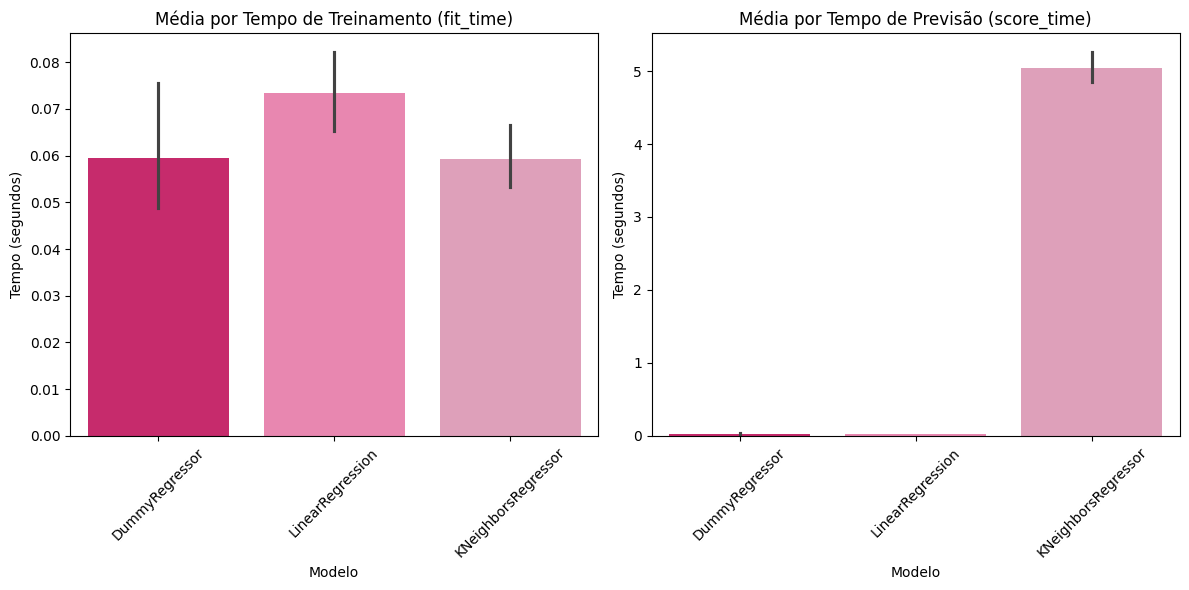

In [79]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=results_total, x='model', y='fit_time', palette=paleta_personalizada)
plt.title('Média por Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=results_total, x='model', y='score_time', palette=paleta_personalizada)
plt.title('Média por Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

C:\Users\micae\AppData\Local\Temp\ipykernel_13968\249727433.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=std_results, x='model', y='fit_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\249727433.py:7: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=std_results, x='model', y='fit_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\249727433.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=std_results, x='model', y='score_time', palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\249727433.py:14: UserWarning

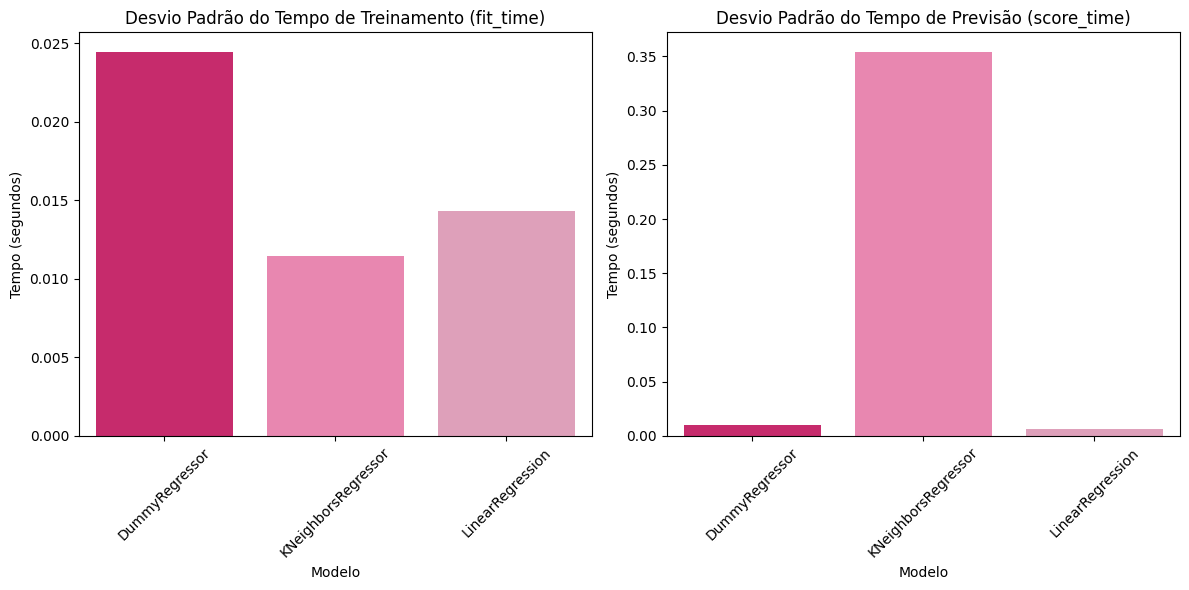

In [60]:
std_results = results_total.groupby('model').std().reset_index()

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
sns.barplot(data=std_results, x='model', y='fit_time', palette=paleta_personalizada)
plt.title('Desvio Padrão do Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=std_results, x='model', y='score_time', palette=paleta_personalizada)
plt.title('Desvio Padrão do Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 1. **fit_time**: Tempo médio (em segundos) para treinar o modelo.
    * **Interpretação**: Quanto menor, mais rápido o modelo é treinado.

    **Resultado**:

    * **DummyRegressor**: 0.0594 s
    * **KNeighborsRegressor**: 0.0592 s
    * **LinearRegression**: 0.0734 s

    **Análise**: O DummyRegressor e o KNeighborsRegressor são mais rápidos para treinar do que o LinearRegression.

2. **score_time**: Tempo médio (em segundos) para fazer predições e calcular as métricas.
    * **Interpretação**: Quanto menor, mais rápido o modelo faz predições.

    **Resultado**:

    * **DummyRegressor**: 0.0261 s
    * **KNeighborsRegressor**: 5.0373 s
    * **LinearRegression**: 0.0238 s

    **Análise**: O KNeighborsRegressor é muito mais lento para fazer predições, pois precisa calcular distâncias entre os pontos de dados. O DummyRegressor e o LinearRegression são muito mais rápidos.

* **Gráficos Comparativos para Métricas**

C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3489962200.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3489962200.py:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3489962200.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3489962200.py:12: UserWarning: 

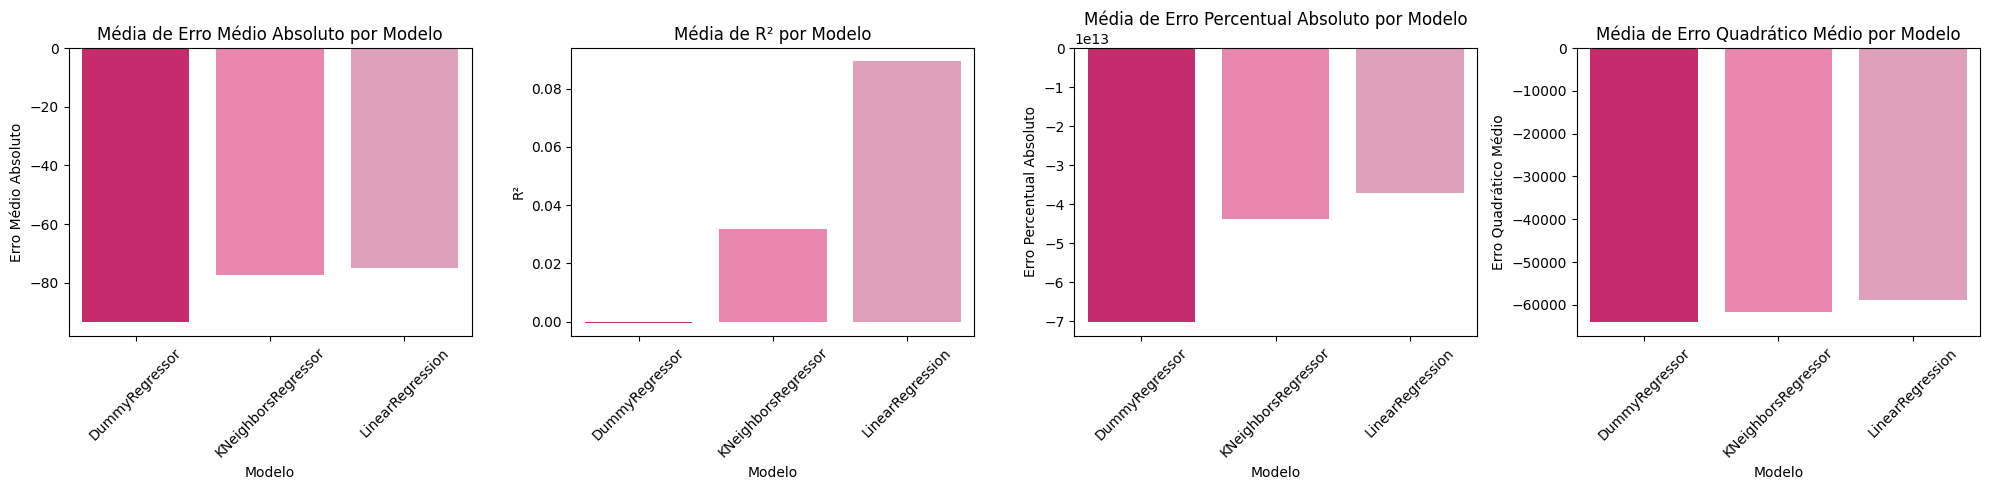

In [77]:
plt.figure(figsize=(20, 5))

metrics = [
    ('mean_test_neg_mean_absolute_error', 'Erro Médio Absoluto'),
    ('mean_test_r2', 'R²'),
    ('mean_test_neg_mean_absolute_percentage_error', 'Erro Percentual Absoluto'),
    ('mean_test_neg_mean_squared_error', 'Erro Quadrático Médio')
]

for i, (metric, title) in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
    plt.title(f'Média de {title} por Modelo')
    plt.ylabel(title)
    plt.xlabel('Modelo')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3945841451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3945841451.py:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3945841451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
C:\Users\micae\AppData\Local\Temp\ipykernel_13968\3945841451.py:12: UserWarning: 

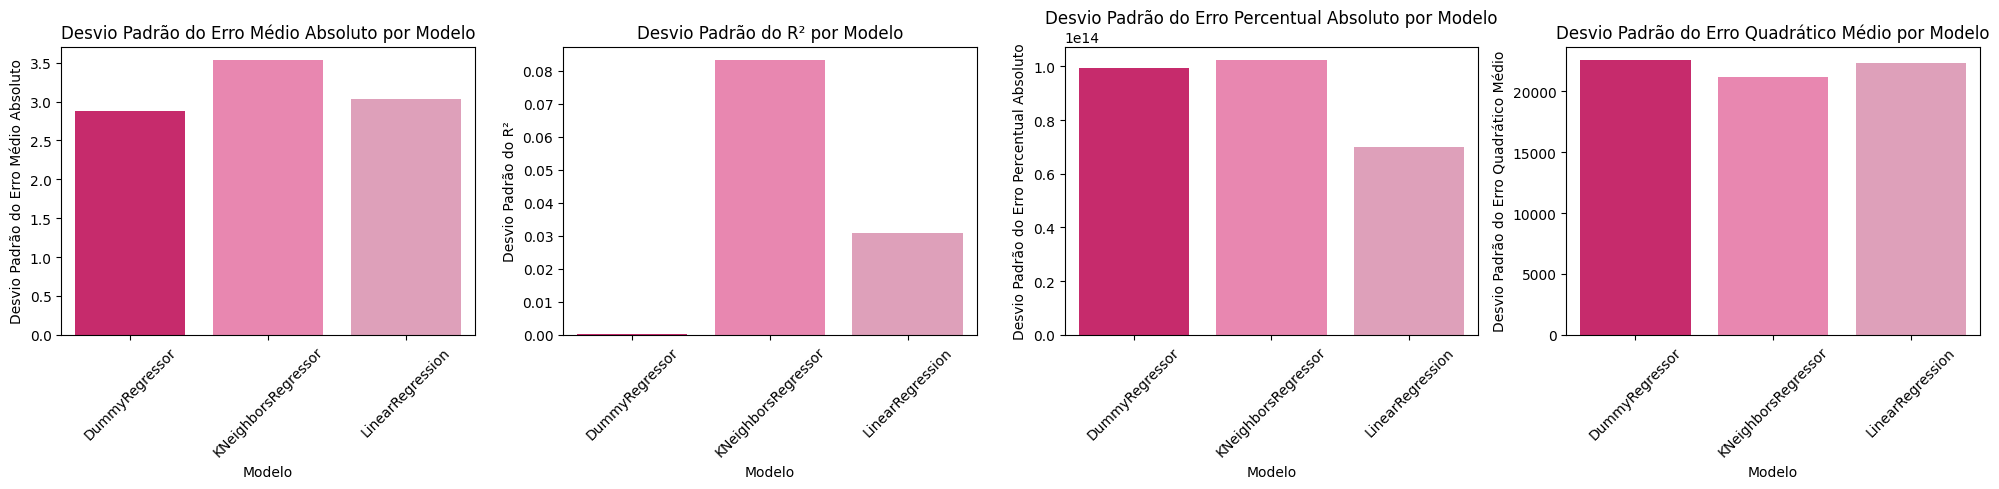

In [78]:
plt.figure(figsize=(20, 5))

metrics = [
    ('std_test_neg_mean_absolute_error', 'Desvio Padrão do Erro Médio Absoluto'),
    ('std_test_r2', 'Desvio Padrão do R²'),
    ('std_test_neg_mean_absolute_percentage_error', 'Desvio Padrão do Erro Percentual Absoluto'),
    ('std_test_neg_mean_squared_error', 'Desvio Padrão do Erro Quadrático Médio')
]

for i, (metric, title) in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=results_pivot, x='model', y=metric, palette=paleta_personalizada)
    plt.title(f'{title} por Modelo')
    plt.ylabel(title)
    plt.xlabel('Modelo')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


1. **test_neg_mean_absolute_error (MAE negativo)**: Média do erro absoluto médio (MAE) nas predições. O valor é negativo porque o Scikit-learn maximiza as métricas, então o sinal é invertido para métricas de erro.

    * **Interpretação**: Quanto mais próximo de zero, melhor. Um valor de -50 significa que o erro médio é 50.

    **Resultado**:

    * **DummyRegressor**: -93.43
    * **KNeighborsRegressor**: -77.40
    * **LinearRegression**: -74.89

    **Análise**: O LinearRegression tem o menor erro absoluto médio, seguido pelo KNeighborsRegressor. O DummyRegressor tem o pior desempenho.

2. **test_neg_mean_squared_error (MSE negativo)**: Média do erro quadrático médio (MSE) nas predições. O valor é negativo pelo mesmo motivo do MAE.

    * **Interpretação**: Quanto mais próximo de zero, melhor. Um valor de -1000 significa que o erro quadrático médio é 1000.

    **Resultado**:

    * **DummyRegressor**: -64001.50
    * **KNeighborsRegressor**: -61533.28
    * **LinearRegression**: -58817.08

    **Análise**: O LinearRegression tem o menor erro quadrático médio, seguido pelo KNeighborsRegressor. O DummyRegressor tem o pior desempenho.

3. **test_neg_mean_absolute_percentage_error (MAPE negativo)**: Média do erro percentual absoluto médio (MAPE) nas predições. O valor é negativo pelo mesmo motivo do MAE.

    * **Interpretação**: Quanto mais próximo de zero, melhor. Um valor de -0.5 significa que o erro percentual médio é 50%.

    **Resultado**:

    * **DummyRegressor**: -7.02e+13
    * **KNeighborsRegressor**: -4.37e+13
    * **LinearRegression**: -3.73e+13

    **Análise**: Os valores estão extremamente altos, o que indica que o MAPE não é uma métrica adequada para este problema. Isso pode acontecer se a variável-alvo (y) contiver valores próximos de zero, pois o MAPE envolve divisão por y.

4. **test_r2 (Coeficiente de Determinação R²)**: Mede a proporção da variância nos dados que é explicada pelo modelo. Varia de -∞ a 1, onde 1 indica um ajuste perfeito.

    * **Interpretação**: Quanto mais próximo de 1, melhor. Valores negativos indicam que o modelo é pior do que um modelo que sempre prevê a média.

    **Resultado**:

    * **DummyRegressor**: -0.000347
    * **KNeighborsRegressor**: 0.0318
    * **LinearRegression**: 0.0894

    **Análise**: O LinearRegression tem o maior R², seguido pelo KNeighborsRegressor. O DummyRegressor tem um R² próximo de zero, o que é esperado, pois ele não aprende nada dos dados.

* Salvando modelo:

In [19]:
with open('regressao.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Modelo salvo com sucesso em 'regressao.pkl'")

Modelo salvo com sucesso em 'regressao.pkl'


### Predição

* Divisão dos dados de Treinamento e Teste:

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Transformando os dados:

In [81]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [82]:
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Shape of X_test_transformed:", X_test_transformed.shape)

Shape of X_train_transformed: (19557, 15)
Shape of X_test_transformed: (4890, 15)


* Treinando modelo com os dados transformados:

In [83]:
trained_models = {}
for model in modelos:
    model_name = type(model).__name__
    model.fit(X_train_transformed, y_train)
    trained_models[model_name] = model

* Fazendo Predição:

In [84]:
predictions = {}
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(X_test_transformed)
    predictions[model_name] = y_pred
    print(f"Predictions for {model_name}:")
    print(y_pred[:5])  

Predictions for DummyRegressor:
[152.58413867 152.58413867 152.58413867 152.58413867 152.58413867]
Predictions for LinearRegression:
[122.65744643 155.28997332 187.74274766  62.71583056  62.54609433]
Predictions for KNeighborsRegressor:
[ 87.4  97.  193.8  73.8  65.4]


* **Caso de Exemplo**: Suponhas que o apartamento tenha as seguintes características: 
``` {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

```
 Qual seria a sua sugestão de preço?


In [262]:
registro_exemplo = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

In [263]:
registro_df = pd.DataFrame([registro_exemplo])

In [264]:
registro_transformed = preprocessor.transform(registro_df)

* Fazendo Predição:

In [265]:
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(registro_transformed)
    print(f"Predição de preço para {model_name}: {y_pred[0]:.2f}")

Predição de preço para DummyRegressor: 152.58
Predição de preço para LinearRegression: 276.51
Predição de preço para KNeighborsRegressor: 346.20


### Análise baseada no modelo:

1. **DummyRegressor**: 152.58

* O DummyRegressor é um modelo "ingênuo" que sempre prevê a média (ou outra estatística simples) da variável-alvo (price) nos dados de treino.
* Interpretação: O valor de 152.58 é a média dos preços dos apartamentos no conjunto de treino. Esse modelo não leva em consideração as características do apartamento, então ele serve apenas como uma linha de base (baseline).

2. **LinearRegression**: 276.51

* O LinearRegression é um modelo linear que tenta capturar relações lineares entre as features e o preço.

* **Interpretação**: O valor de 276.51 é a predição do modelo linear. Ele sugere que, com base nas características do apartamento (localização, tipo de quarto, número de reviews, etc.), o preço esperado é cerca de 276.51.

3. **KNeighborsRegressor**: 346.20

* O KNeighborsRegressor é um modelo baseado em vizinhança que prevê o preço com base nos preços dos apartamentos mais semelhantes no conjunto de treino.

* **Interpretação**: O valor de 346.20 é a predição do modelo de vizinhança. Ele sugere que, com base em apartamentos semelhantes, o preço esperado é cerca de 346.20.

### Análise baseada nos dados:

* O apartamento está localizado em Manhattan, uma das áreas mais caras de Nova York, o que justifica um preço mais alto.

* O tipo de quarto é "Entire home/apt", que geralmente é mais caro do que quartos compartilhados.

* O número de reviews (45) e a disponibilidade (355 dias por ano) sugerem que o apartamento é popular e bem avaliado, o que também pode justificar um preço mais alto.

### Preço Sugerido:

* Utilizando a Média de Predição dos dois modelos mais confiáveis (276.51 + 346.20) / 2 = 311.36, chegamos a conclusão que o modelo ideal seria o KNeighborsRegressor por se aproximar mais desse valor e pela análise baeada nos dados ser um valor alto.
* Preço sugerido: 346.20

## Modelos de Classificação

### Avaliação dos Modelos

* Definição dos modelos e armazenamento em Reports:

In [21]:
modelos = [
    LogisticRegression(),
    KNeighborsClassifier()
]

In [22]:
reports = {}

* Divisão dos y em quartis (4 categorias)

In [23]:
y_categorical = pd.qcut(y, q=4, labels=["Muito Baixa", "Baixa", "Alta", "Muito Alta"])
print("Categorias geradas:", y_categorical.unique())

Categorias geradas: ['Alta', 'Muito Baixa', 'Muito Alta', 'Baixa']
Categories (4, object): ['Muito Baixa' < 'Baixa' < 'Alta' < 'Muito Alta']


* Divisão dos dados em treino e teste:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [89]:
print("Tamanho de X_train:", X_train.shape[0])
print("Tamanho de y_train:", len(y_train))

Tamanho de X_train: 19557
Tamanho de y_train: 19557


* Treinamento do Modelo:

In [25]:
for model in modelos:
    model_name = model.__class__.__name__
    print(f"Treinando e avaliando o modelo: {model_name}")
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=False)
    print(f"Relatório de classificação para {model_name}:\n{report}")
    
    reports[model_name] = classification_report(y_test, y_pred, output_dict=True)

Treinando e avaliando o modelo: LogisticRegression
Relatório de classificação para LogisticRegression:
              precision    recall  f1-score   support

        Alta       0.42      0.37      0.39      1173
       Baixa       0.41      0.30      0.34      1178
  Muito Alta       0.56      0.65      0.60      1230
 Muito Baixa       0.63      0.77      0.69      1309

    accuracy                           0.53      4890
   macro avg       0.51      0.52      0.51      4890
weighted avg       0.51      0.53      0.51      4890

Treinando e avaliando o modelo: KNeighborsClassifier
Relatório de classificação para KNeighborsClassifier:
              precision    recall  f1-score   support

        Alta       0.39      0.45      0.41      1173
       Baixa       0.38      0.37      0.37      1178
  Muito Alta       0.57      0.52      0.54      1230
 Muito Baixa       0.66      0.63      0.64      1309

    accuracy                           0.50      4890
   macro avg       0.50      

* **Matriz de Confusão**

Gerando matriz de confusão para o modelo: LogisticRegression
Gerando matriz de confusão para o modelo: KNeighborsClassifier


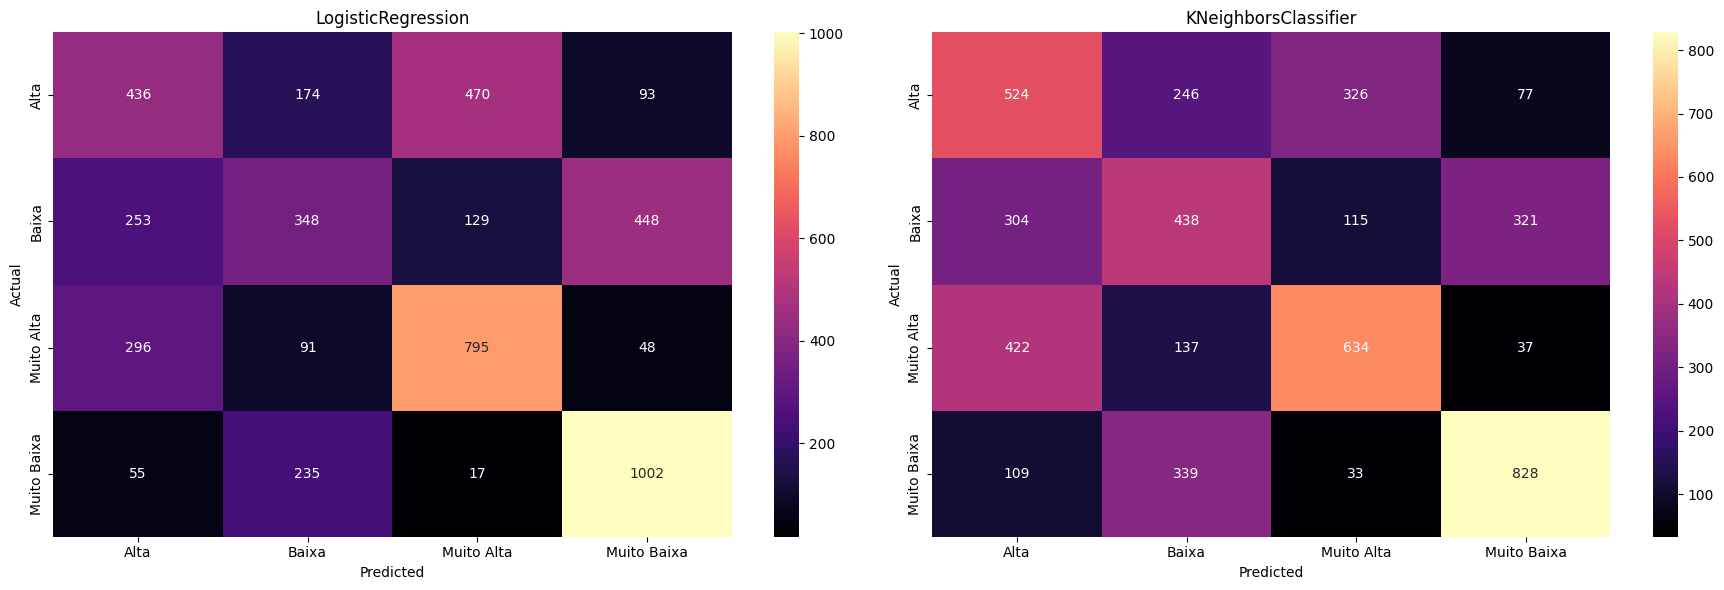

In [103]:
cores_personalizadas = sns.color_palette("magma", as_cmap=True)

fig, axes = plt.subplots(1, len(modelos), figsize=(18, 6))

for i, model in enumerate(modelos):
    model_name = model.__class__.__name__
    print(f"Gerando matriz de confusão para o modelo: {model_name}")
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, ax=axes[i],  cmap=cores_personalizadas)
    axes[i].set_title(f"{model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

1. **Acurácia**
    * **LogisticRegression**: 0.53
    * **KNeighborsClassifier**: 0.50

    **Análise**:
    * A Logistic Regression teve um desempenho ligeiramente melhor em termos de acurácia do que o KNeighbors Classifier. Isso pode indicar que a Regressão Logística está capturando mais corretamente as predições gerais, mesmo que o ganho não seja muito significativo.

2. **Precision, Recall e F1-Score**
    *  **Logistic Regression**:
        * **Alta**: Precision = 0.42, Recall = 0.37, F1-score = 0.39
        * **Baixa**: Precision = 0.41, Recall = 0.30, F1-score = 0.34
        * **Muito Alta**: Precision = 0.56, Recall = 0.65, F1-score = 0.60
        * **Muito Baixa**: Precision = 0.63, Recall = 0.77, F1-score = 0.69

    *  **KNeighbors Classifier**:
        * **Alta**: Precision = 0.39, Recall = 0.45, F1-score = 0.41
        * **Baixa**: Precision = 0.38, Recall = 0.37, F1-score = 0.37
        * **Muito Alta**: Precision = 0.57, Recall = 0.52, F1-score = 0.54
        * **Muito Baixa**: Precision = 0.66, Recall = 0.63, F1-score = 0.64

    * **Análise**:
        * **Classe Alta**: Ambos os modelos têm um desempenho ruim para a classe "Alta", com KNeighbors Classifier mostrando um melhor recall (indica que ele é mais capaz de identificar instâncias dessa classe), mas a precisão é baixa para ambos os modelos. Isso pode sugerir que os modelos estão cometendo falsos positivos para essa classe.

        * **Clase Baixa**: ara a classe "Baixa", ambos os modelos têm baixo desempenho, mas o KNeighbors Classifier é um pouco mais equilibrado em termos de precisão e recall. Contudo, nenhum dos modelos tem desempenho robusto para essa classe, o que sugere que talvez essa classe seja mais difícil de prever ou tenha menos exemplos no conjunto de dados.

        * **Classe Muito Alta**:  Ambos os modelos têm um desempenho relativamente bom para a classe "Muito Alta", mas a Regressão Logística apresenta um recall superior, o que significa que está identificando mais corretamente as instâncias dessa classe. Embora a precisão seja semelhante entre os dois modelos, o Logistic Regression pode ser mais útil para garantir a identificação da classe "Muito Alta".

        * **Classe Muito Baixa**:  O modelo Logistic Regression é mais eficiente para a classe "Muito Baixa" devido ao maior recall, o que significa que está identificando mais corretamente as instâncias dessa classe. O KNeighbors Classifier tem uma precisão um pouco melhor, mas seu recall menor sugere que ele está perdendo algumas instâncias importantes dessa classe.

3. **Macro e Weighted Average**

    * **Logistic Regression**:
        * **Macro avg**: Precision 0.51, Recall 0.52, F1-score 0.51
        * **Weighted avg**: Precision 0.51, Recall 0.53, F1-score 0.51

    * **KNeighbors Classifier**
        * **Macro avg**: Precision 0.50, Recall 0.49, F1-score 0.49
        * **Weighted avg**: Precision 0.50, Recall 0.50, F1-score 0.50

    * **Análise**:
        * A Regressão Logística tem um desempenho ligeiramente melhor tanto em média macro quanto ponderada, o que indica que ela lida de forma mais equilibrada com todas as classes em comparação com o KNeighbors Classifier
        * O modelo KNeighbors Classifier tem desempenho ligeiramente inferior em todas as métricas médias.


* Salvando o Modelo:

In [26]:
with open('classificacao.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Modelo salvo com sucesso em 'classificacao.pkl'")

Modelo salvo com sucesso em 'classificacao.pkl'


### Predição

* **Caso de Exemplo**: Suponhas que o apartamento tenha as seguintes características: 
``` {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

```
 Qual seria a sua sugestão de categoria de preço?

In [105]:
registro_exemplo = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

In [106]:
registro_df = pd.DataFrame([registro_exemplo])

In [107]:
predictions = {}

In [109]:
predictions = {}
probabilities = {}  

for model in modelos:
    model_name = model.__class__.__name__
    print(f"Fazendo previsão com o modelo: {model_name}")
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    pipeline.fit(X, y_categorical)
    
    pred_classes = pipeline.predict(registro_df)
    
    predictions[model_name] = pred_classes

    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        pred_probs = pipeline.predict_proba(registro_df)
        probabilities[model_name] = pred_probs  

for model_name, preds in predictions.items():
    print(f"Previsões de classes para {model_name}: {preds}")
    if model_name in probabilities:
        print(f"Probabilidades das classes para {model_name}:")
        for i, prob in enumerate(probabilities[model_name]):
            print(f"Dado {i + 1}: {prob}")

Fazendo previsão com o modelo: LogisticRegression
Fazendo previsão com o modelo: KNeighborsClassifier
Previsões de classes para LogisticRegression: ['Muito Alta']
Probabilidades das classes para LogisticRegression:
Dado 1: [1.87172681e-01 1.96079838e-02 7.92535097e-01 6.84238472e-04]
Previsões de classes para KNeighborsClassifier: ['Muito Alta']
Probabilidades das classes para KNeighborsClassifier:
Dado 1: [0. 0. 1. 0.]



* **Análise de Predições**: Ambos os modelos, LogisticRegression e KNeighborsClassifier, preveram que a classe do apartamento é "Muito Alta", ou seja com base nas características fornecidas, o apartamento possui um valor elevado comparado a outros imóveis na base de dados.

* **Probabilidades das classes**

    * **LogisticRegression**:
        * **Classe "Alta"**: 0.187
        * **Classe "Baixa"**: 0.019
        * **Classe "Muito Alta"**: 0.792
        * **Classe "Muito Baixa"**: 0.00068

    **Análise**: 
    A classe "Muito Alta" tem a probabilidade mais alta (79.2%), o que confirma a alta categoria de preço para este apartamento. As probabilidades para as classes "Baixa" e "Muito Baixa" são extremamente baixas, indicando que o modelo vê esse apartamento como significativamente caro em comparação com os outros imóveis.

    * **KNeighborsClassifier**:
        * **Classe "Alta"**: 0
        * **Classe "Baixa"**: 0
        * **Classe "Muito Alta"**: 1
        * **Classe "Muito Baixa"**: 0

    **Análise**:
    O KNeighborsClassifier também classifica o apartamento como "Muito Alta" com 100% de probabilidade, sugerindo que a similaridade com apartamentos classificados como "Muito Alta" no conjunto de treino é muito alta. O modelo não indica nenhuma possibilidade de ser "Baixa" ou "Muito Baixa", confirmando novamente que este apartamento é considerado de alto valor.

## 5. Modelo de Agrupamento

Nessa parte do projeto , queremos encontrar um conjunto de perfis médios de dados dos imóveis e alocar ao perfil mais próximo dele.

1. Qual a quantidade de Grupos ?
2. Qual a característica de cada Grupo?
3. Como calcular a distância entre o grupo ?

### K-Médias

O agrupamento em k-médias buscar alocar o conjunto de dados em K grupos ou Clusters para seu grupo mais próximo.

In [3]:
model = KMeans()

In [6]:
dados.head()

,nome,host_name,bairro_group,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Outros,Outros,Manhattan,Private room,110,3,47,0.57,1,248
1,Outros,Outros,Brooklyn,Private room,40,1,1,1.00,2,151
2,Outros,Outros,Brooklyn,Private room,57,3,33,0.85,3,345
3,Outros,Outros,Brooklyn,Entire home/apt,375,2,14,0.60,1,75
4,Outros,Outros,Queens,Private room,195,4,0,0.72,1,0


Vamos utilizar as colunas que tem mais influência sobre o preço dos imovéis, como foi visto na análise exploratório na pergunta 9.

In [14]:
data = dados[['disponibilidade_365','calculado_host_listings_count','minimo_noites', 'price']]

In [15]:
data.head()

,disponibilidade_365,calculado_host_listings_count,minimo_noites,price
0,248,1,3,110
1,151,2,1,40
2,345,3,3,57
3,75,1,2,375
4,0,1,4,195


### Treino:

Nesse caso de agrupamento em K-Médias estamos interessados em definir os centróides de um número de clusters pré-selecionados a partir de um métrica de distância.

In [16]:
model = KMeans(n_clusters=5)
model = model.fit(data)

In [17]:
model.__dict__

{'n_clusters': 5,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'n_init': 'auto',
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'algorithm': 'lloyd',
 'feature_names_in_': array(['disponibilidade_365', 'calculado_host_listings_count',
        'minimo_noites', 'price'], dtype=object),
 'n_features_in_': 4,
 '_tol': 1.889795851945724,
 '_n_init': 1,
 '_algorithm': 'lloyd',
 '_n_threads': 10,
 'cluster_centers_': array([[2.50410995e+01, 2.04793845e+00, 5.07772736e+00, 1.14413560e+02],
        [1.58095238e+02, 2.00000000e+00, 2.91428571e+01, 5.88085714e+03],
        [2.82044979e+02, 1.54955693e+01, 1.06772288e+01, 1.23752148e+02],
        [1.92744526e+02, 2.49635036e+00, 1.43357664e+01, 1.48508029e+03],
        [1.56996940e+02, 1.88212974e+01, 7.24418605e+00, 4.49699510e+02]]),
 '_n_features_out': 5,
 'labels_': array([2, 0, 2, ..., 0, 2, 0]),
 'inertia_': 407197414.6102837,
 'n_iter_': 27}

* Após o treinamento, vamos visualizar os agrupamentos:

In [18]:
clusters = model.labels_
clusters = pd.DataFrame(clusters, columns=['cluster'])
clusters.head()

,cluster
0,2
1,0
2,2
3,4
4,0


In [19]:
clustered_data = pd.concat([data, clusters], axis=1)
clustered_data.head()

,disponibilidade_365,calculado_host_listings_count,minimo_noites,price,cluster
0,248,1,3,110,2
1,151,2,1,40,0
2,345,3,3,57,2
3,75,1,2,375,4
4,0,1,4,195,0


c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has mo

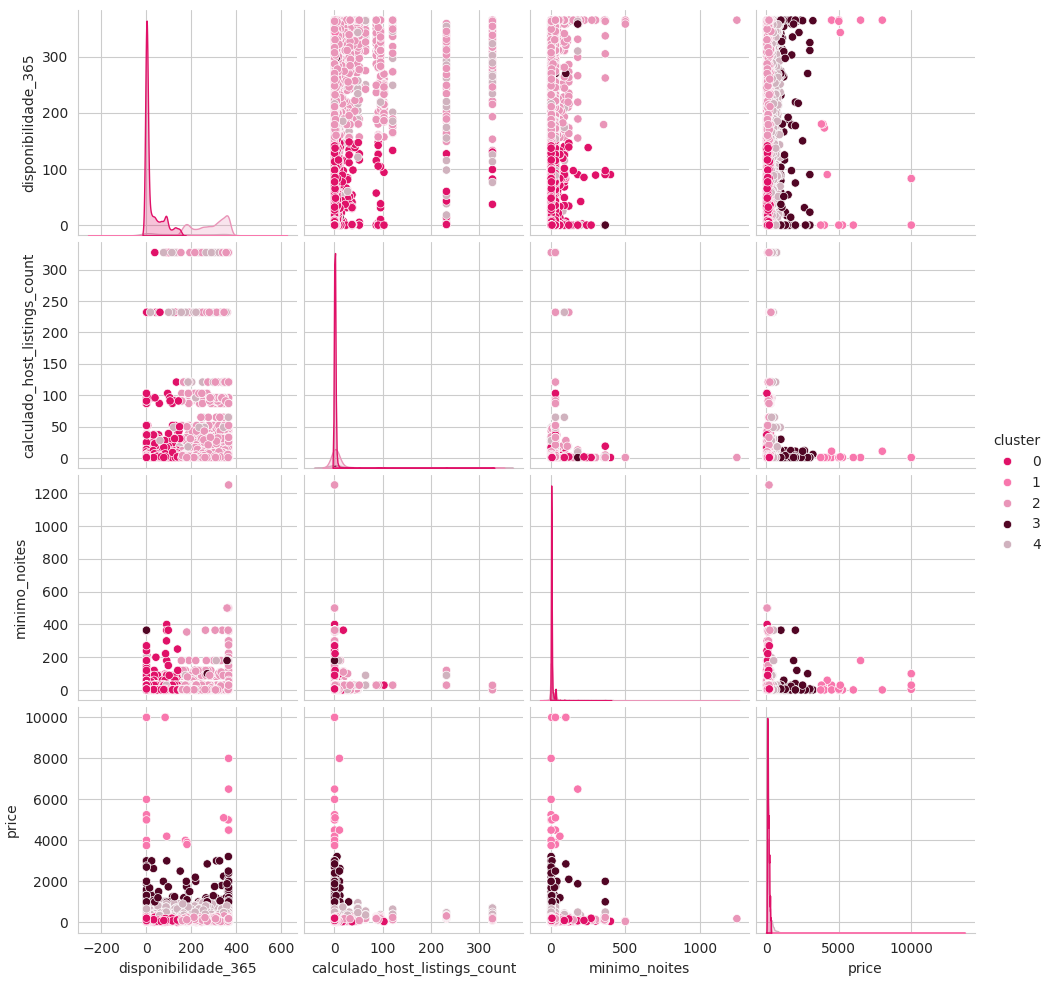

In [23]:
with sns.axes_style('whitegrid'):

  grafico = sns.pairplot(data=clustered_data, hue='cluster',palette=paleta_personalizada)

* Posição dos centróides:

Centróides são os pontos médios de cada grupo, representando a média das características dos dados dentro de cada cluster.

In [25]:

clusters_centers = model.cluster_centers_
clusters_centers = pd.DataFrame(clusters_centers, columns=['disponibilidade_365','calculado_host_listings_count','minimo_noites','price'])
clusters_centers.head()

,disponibilidade_365,calculado_host_listings_count,minimo_noites,price
0,25.041099,2.047938,5.077727,114.413560
1,158.095238,2.000000,29.142857,5880.857143
2,282.044979,15.495569,10.677229,123.752148
3,192.744526,2.496350,14.335766,1485.080292
4,156.996940,18.821297,7.244186,449.699510


C:\Users\micae\AppData\Local\Temp\ipykernel_20280\678394612.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=clustered_data, x='calculado_host_listings_count', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[0])
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\678394612.py:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=clustered_data, x='disponibilidade_365', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[1])
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\678394612.py:11: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=clustered_data, x='minimo_noites', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[2])


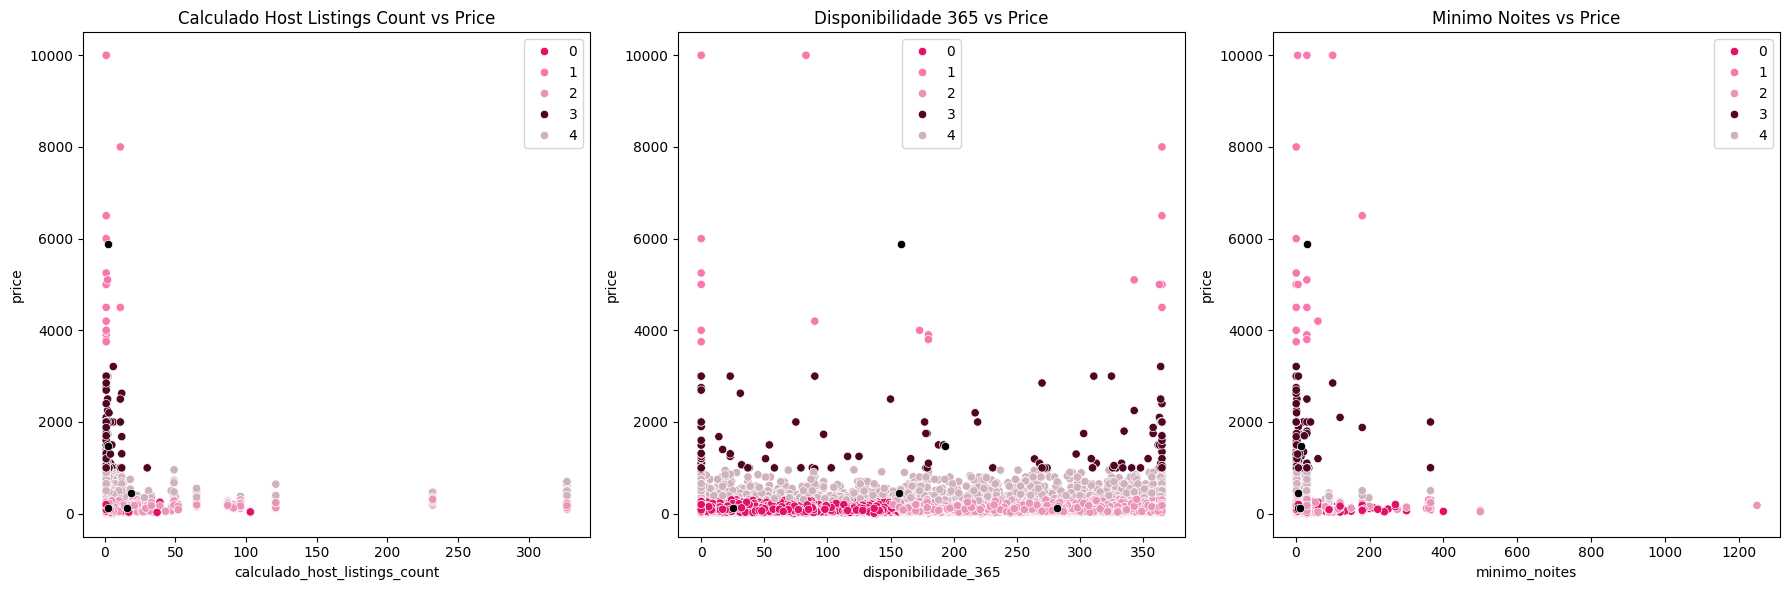

In [36]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data, x='calculado_host_listings_count', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[0])
sns.scatterplot(data=clusters_centers, x='calculado_host_listings_count', y='price', color='black', ax=axes[0])
axes[0].set_title('Calculado Host Listings Count vs Price')

sns.scatterplot(data=clustered_data, x='disponibilidade_365', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[1])
sns.scatterplot(data=clusters_centers, x='disponibilidade_365', y='price', color='black', ax=axes[1])
axes[1].set_title('Disponibilidade 365 vs Price')

sns.scatterplot(data=clustered_data, x='minimo_noites', y='price', hue='cluster', palette=paleta_personalizada, ax=axes[2])
sns.scatterplot(data=clusters_centers, x='minimo_noites', y='price', color='black', ax=axes[2])
axes[2].set_title('Minimo Noites vs Price')


plt.tight_layout()
plt.show()

Acima temos 5 centróides, um para cada cluster. Cada um contém valores médios para as características listadas em relação ao preço que é o foco na análise.

### Avaliação:

O WCSS mede o quão próximo o centróide de um cluster está dos objetos alocados, se o WCSS é baixo, os objetos estão próximos entre si. Para buscar uma boa generalização vamos utilizar o método do cotovelo:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\930638926.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  grafico = sns.lineplot(x=range(1,11), y=wcss, marker="8",palette=paleta_personalizada)


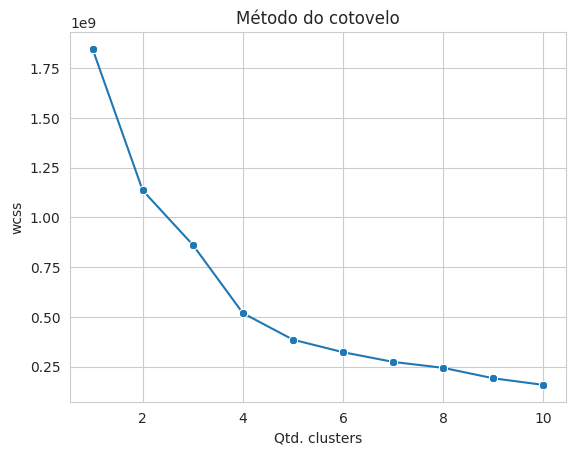

In [37]:
wcss = []

for k in range(1, 11):

  model = KMeans(n_clusters=k)
  model = model.fit(data)
  wcss.append(model.inertia_)
     

with sns.axes_style('whitegrid'):

  grafico = sns.lineplot(x=range(1,11), y=wcss, marker="8",palette=paleta_personalizada)
  grafico.set(title='Método do cotovelo', ylabel='wcss', xlabel='Qtd. clusters');
     

Observamos que os objetos estão próximos entre si.

* **4 clusters**:

c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has mo

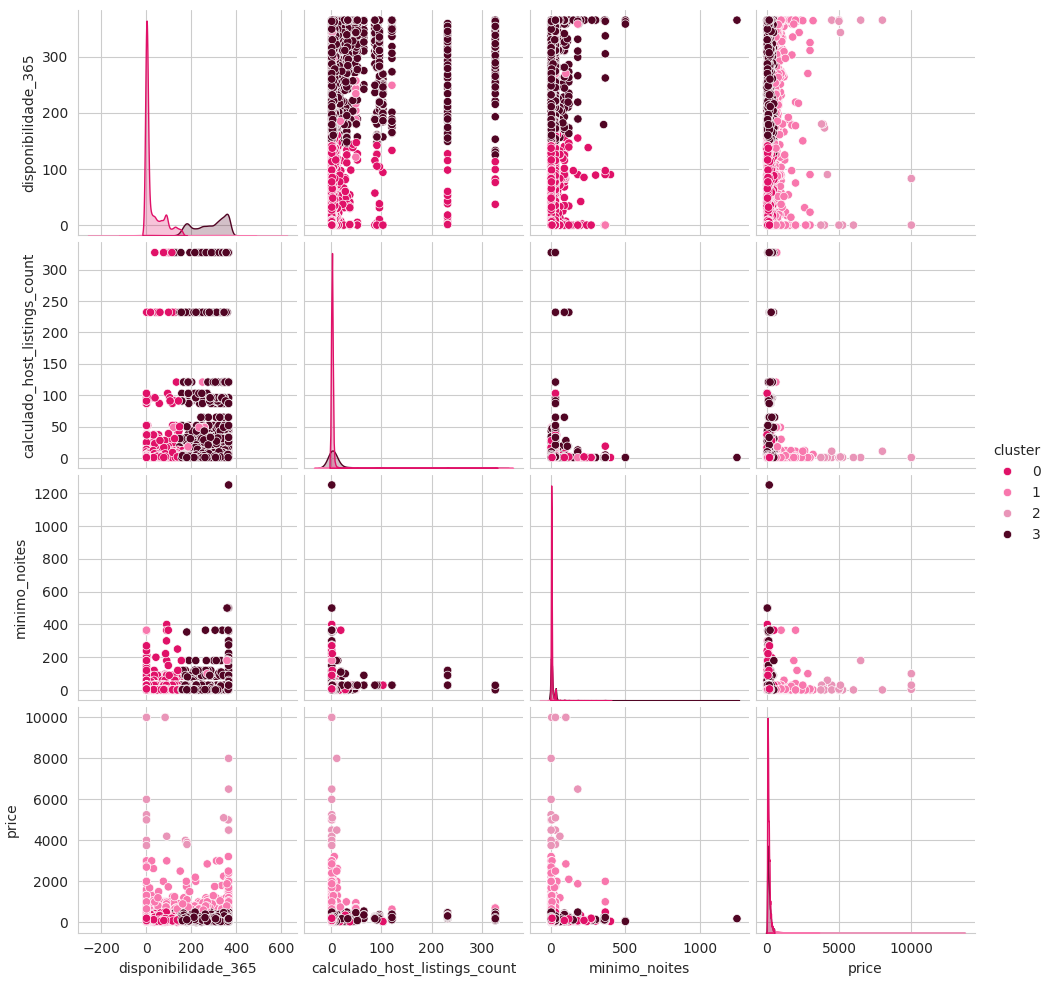

In [38]:
model = KMeans(n_clusters= 4)
model = model.fit(data)

clusters = model.labels_
clustered_data = pd.concat([data, pd.DataFrame(clusters, columns=['cluster'])], axis=1)

with sns.axes_style('whitegrid'):

  grafico = sns.pairplot(data=clustered_data, hue='cluster',palette=paleta_personalizada)

* **6 clusters**:

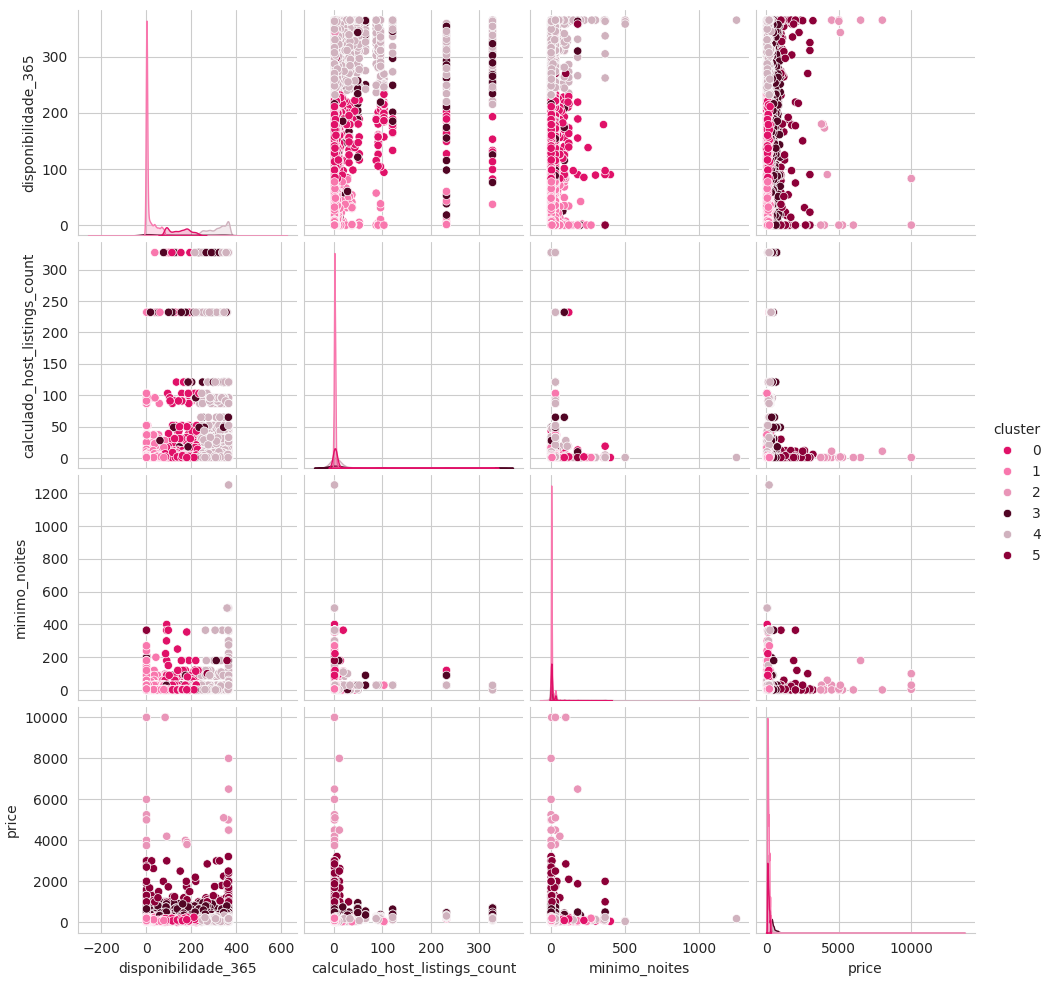

In [39]:
model = KMeans(n_clusters= 6)
model = model.fit(data)

clusters = model.labels_
clustered_data = pd.concat([data, pd.DataFrame(clusters, columns=['cluster'])], axis=1)

with sns.axes_style('whitegrid'):

  grafico = sns.pairplot(data=clustered_data, hue='cluster',palette=paleta_personalizada)
     

* **5 clusters**:

c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has mo

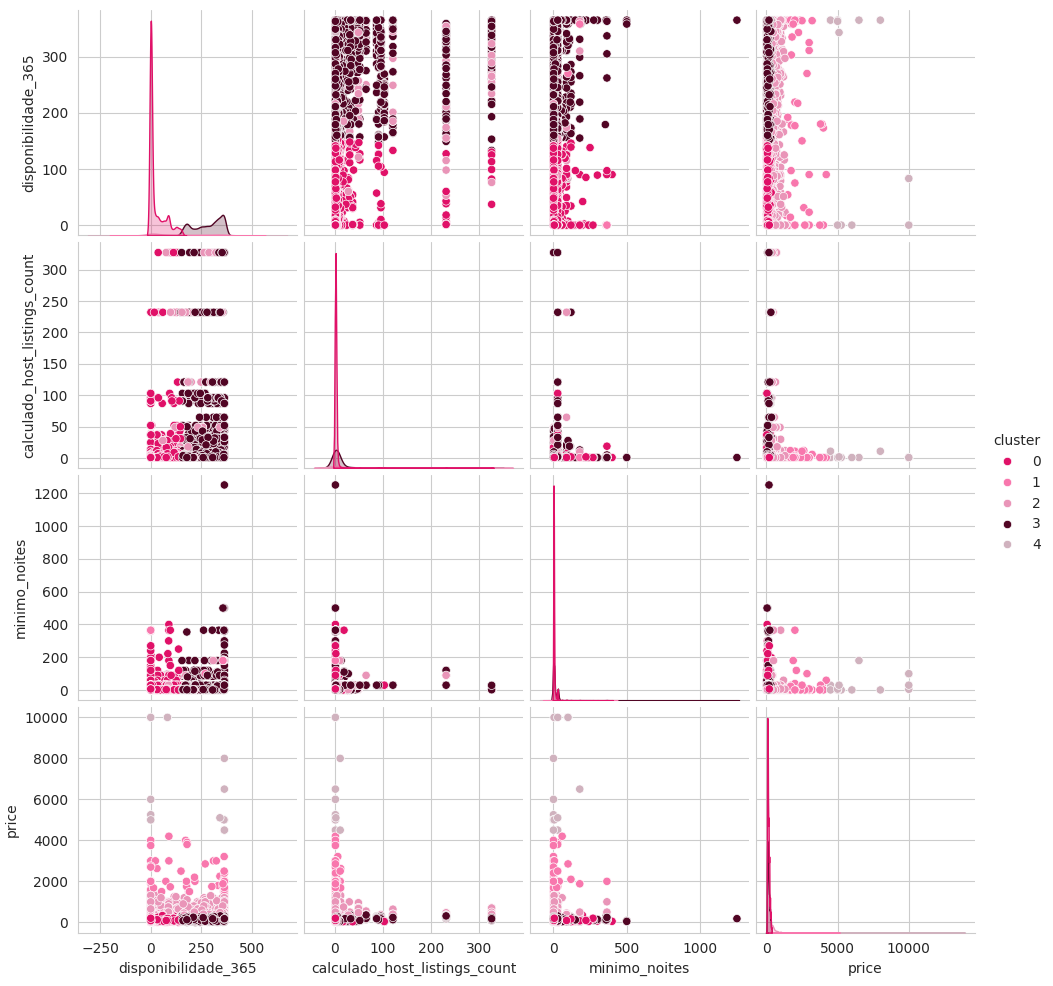

In [40]:
model = KMeans(n_clusters = 5)
model = model.fit(data)

clusters = model.labels_
clustered_data = pd.concat([data, pd.DataFrame(clusters, columns=['cluster'])], axis=1)

with sns.axes_style('whitegrid'):

  grafico = sns.pairplot(data=clustered_data, hue='cluster',palette=paleta_personalizada)

* Salvando o modelo:

In [63]:
with open('agrupamento.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Modelo salvo com sucesso em 'agrupamento.pkl'")

Modelo salvo com sucesso em 'agrupamento.pkl'


### Predição

Após toda as etapas de treinamento, avaliação e seleção podemos utilizar o modelo para resolver problemas com dados reais e gerar insights.

* ### Estudos dos Clusters

* **Cluster 0**:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3401212551.py:4: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 0'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3401212551.py:11: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 0'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3401212551.py:18: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 0'),


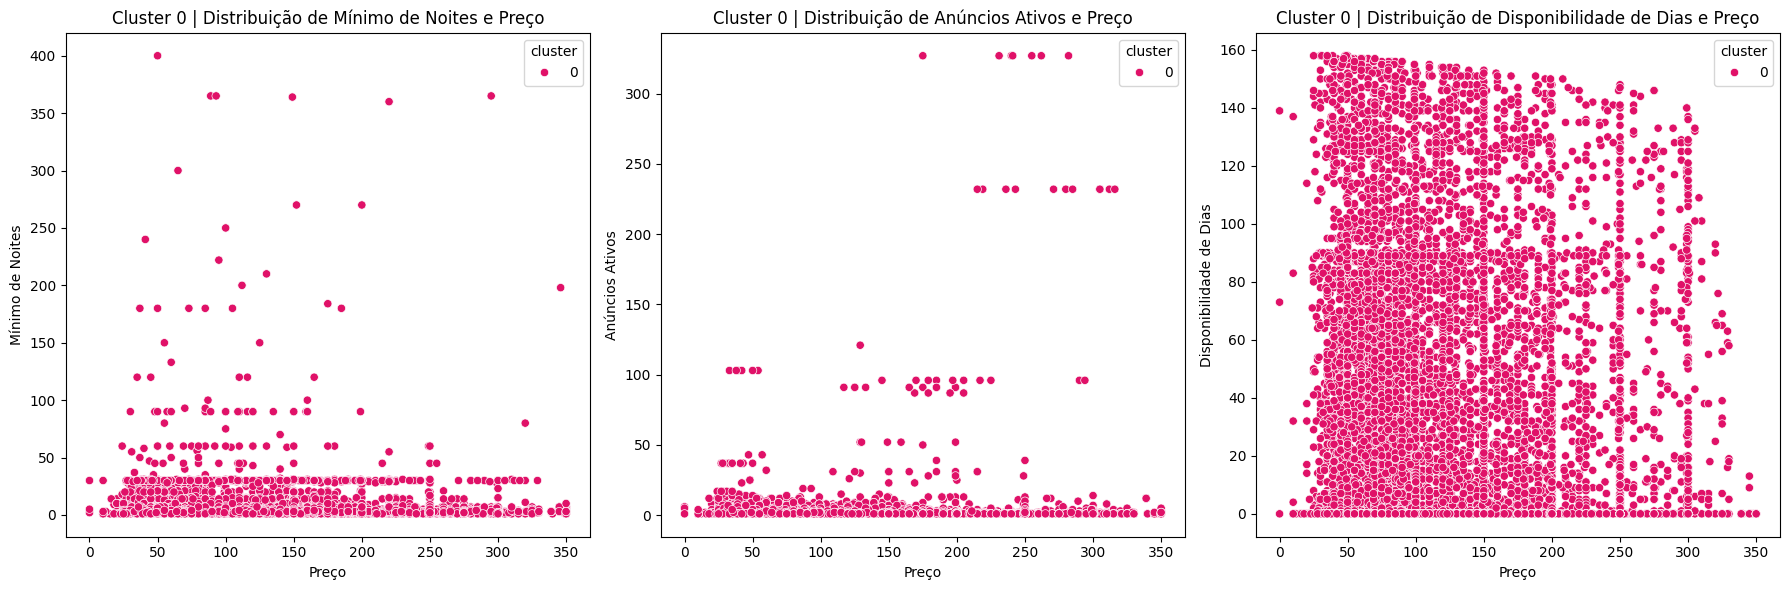

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data.query('cluster == 0'), 
                x="price", y="minimo_noites", 
                hue="cluster", palette=paleta_personalizada, ax=axes[0])
axes[0].set(title='Cluster 0 | Distribuição de Mínimo de Noites e Preço', xlabel='Preço', ylabel='Mínimo de Noites')
axes[0].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 0'), 
                x="price", y="calculado_host_listings_count", 
                hue="cluster", palette=paleta_personalizada, ax=axes[1])
axes[1].set(title='Cluster 0 | Distribuição de Anúncios Ativos e Preço', xlabel='Preço', ylabel='Anúncios Ativos')
axes[1].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 0'), 
                x="price", y="disponibilidade_365", 
                hue="cluster", palette=paleta_personalizada, ax=axes[2])
axes[2].set(title='Cluster 0 | Distribuição de Disponibilidade de Dias e Preço', xlabel='Preço', ylabel='Disponibilidade de Dias')
axes[2].get_legend().set_title("cluster")

plt.tight_layout()
plt.show()

0. **Análise**:
    * **Distribuição de Mínimo de Noites e Preço**: O mínimo de noites varia de 0 a 400, enquanto o preço está entre 0 e 350. Observamos uma maior concentração para valores entre 0 e 50 noites, com uma ampla variação de preço dentro desse intervalo.

    * **Distribuição de Anúncios Ativos e Preço**: Os anúncios ativos variam de 0 a 300, enquanto o preço oscila entre 0 e 350. Observamos uma maior concentração de anúncios ativos entre 0 e 50, com uma ampla variação de preços. Além disso, há uma menor concentração de anúncios na faixa dos 100 e outra ainda menor acima dos 240 e 300.

    * **Distribuição de Disponibilidade de Dias e Preço**: A disponibilidade de dias varia de 0 a 160, enquanto o preço está entre 0 e 350. Observamos uma distribuição espalhada ao longo do gráfico, mas com uma maior concentração de dados para preços abaixo de 200. Após esse valor, os dados se tornam gradativamente mais escassos.

**Resumo do perfil de dados**: Este cluster apresenta uma grande quantidade de dados, com a maior parte das ofertas concentrada em faixas de preços mais acessíveis e baixa exigência de noites mínimas.

* **Cluster 1**:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3816844144.py:3: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 1'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3816844144.py:9: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 1'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3816844144.py:15: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 1'),


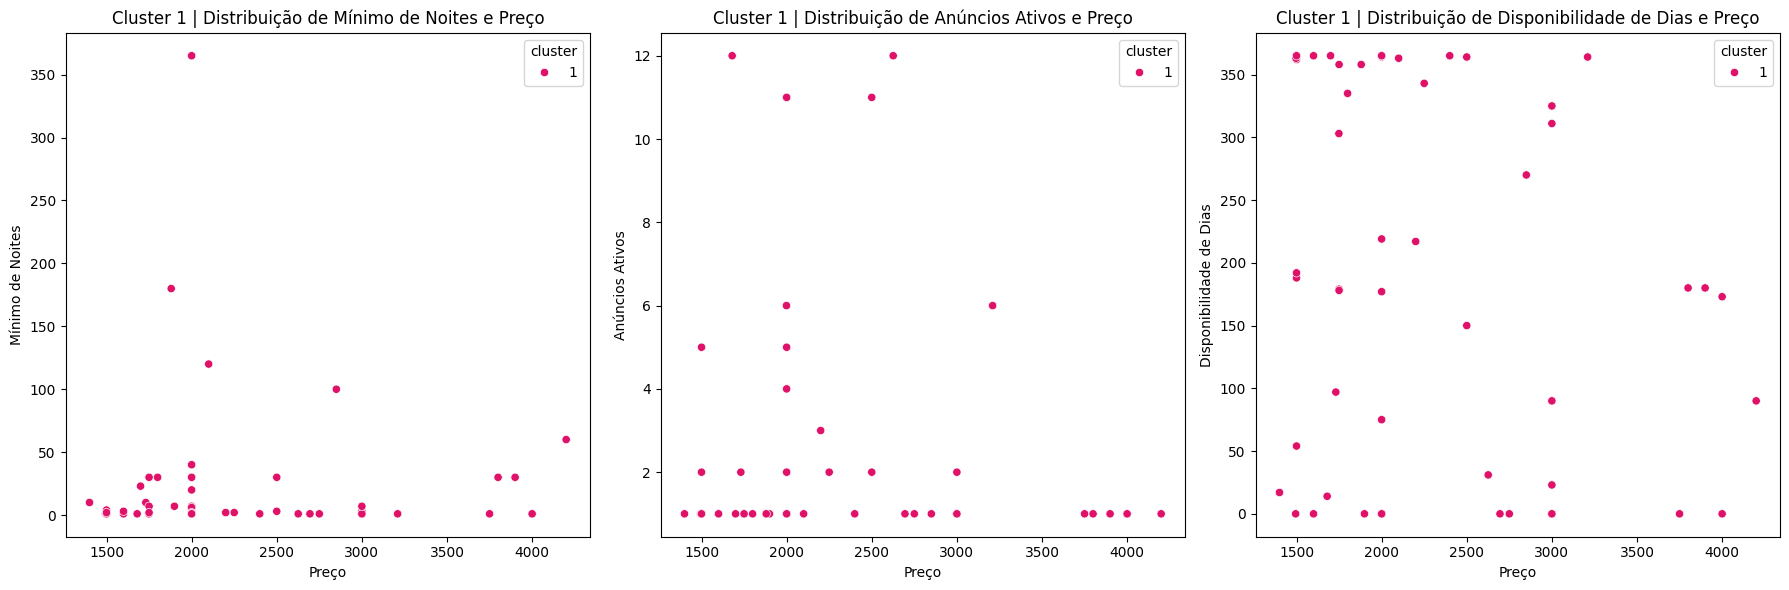

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data.query('cluster == 1'), 
                x="price", y="minimo_noites", 
                hue="cluster", palette=paleta_personalizada, ax=axes[0])
axes[0].set(title='Cluster 1 | Distribuição de Mínimo de Noites e Preço', xlabel='Preço', ylabel='Mínimo de Noites')
axes[0].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 1'), 
                x="price", y="calculado_host_listings_count", 
                hue="cluster", palette=paleta_personalizada, ax=axes[1])
axes[1].set(title='Cluster 1 | Distribuição de Anúncios Ativos e Preço', xlabel='Preço', ylabel='Anúncios Ativos')
axes[1].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 1'), 
                x="price", y="disponibilidade_365", 
                hue="cluster", palette=paleta_personalizada, ax=axes[2])
axes[2].set(title='Cluster 1 | Distribuição de Disponibilidade de Dias e Preço', xlabel='Preço', ylabel='Disponibilidade de Dias')
axes[2].get_legend().set_title("cluster")

plt.tight_layout()
plt.show()

1. **Análise**:
    * **Distribuição de Mínimo de Noites e Preço**: O mínimo de noites varia de 0 a 350, enquanto o preço oscila entre 1.500 e 4.000. Há uma quantidade significativamente menor de dados em comparação com o cluster anterior, sendo a maior concentração na faixa de 0 a 50 noites. Poucos registros ultrapassam esse intervalo.

    * **Distribuição de Anúncios Ativos e Preço**: Os anúncios ativos variam de 1 a 12, enquanto o preço está entre 1.500 e 4.000. A maioria dos registros está concentrada entre 1 e 2 anúncios, sendo que anúncios com valor 2 possuem preços de até 3.000. Há poucos registros fora dessa faixa.

    * **Distribuição de Disponibilidade de Dias e Preço**: A disponibilidade de dias varia de 0 a 350, enquanto o preço está entre 1.500 e 4.000. Há uma concentração de dados maior antes dos 25 dias e outra acima dos 340 dias, com variação nos preços e poucos registros espalhados ao longo do gráfico.

**Resumo do perfil de dados**: Este cluster representa uma faixa de preços mais elevada e menos comum, com menor quantidade de anúncios e exigência moderada de noites mínimas.

* **Cluster 2**:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\817145925.py:3: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 2'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\817145925.py:9: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 2'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\817145925.py:15: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 2'),


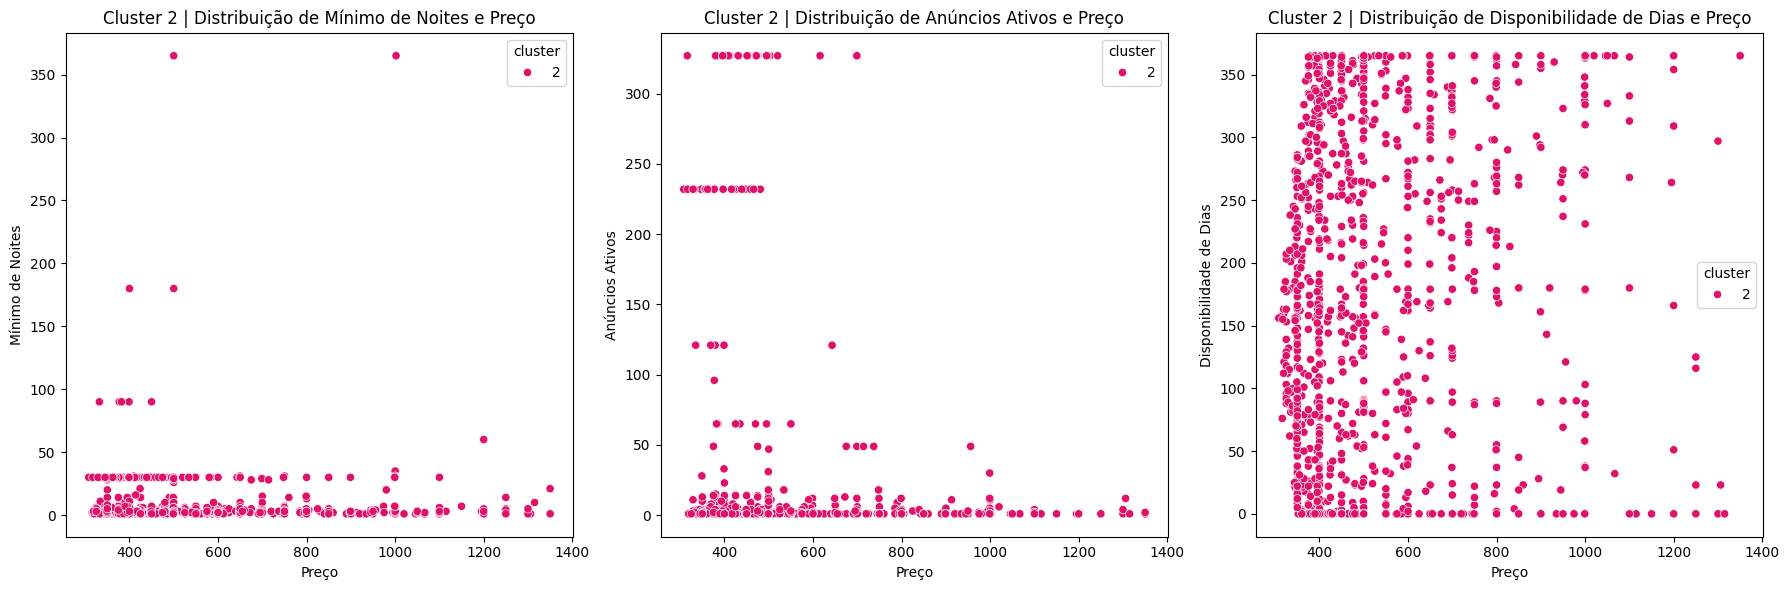

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data.query('cluster == 2'), 
                x="price", y="minimo_noites", 
                hue="cluster", palette=paleta_personalizada, ax=axes[0])
axes[0].set(title='Cluster 2 | Distribuição de Mínimo de Noites e Preço', xlabel='Preço', ylabel='Mínimo de Noites')
axes[0].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 2'), 
                x="price", y="calculado_host_listings_count", 
                hue="cluster", palette=paleta_personalizada, ax=axes[1])
axes[1].set(title='Cluster 2 | Distribuição de Anúncios Ativos e Preço', xlabel='Preço', ylabel='Anúncios Ativos')
axes[1].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 2'), 
                x="price", y="disponibilidade_365", 
                hue="cluster", palette=paleta_personalizada, ax=axes[2])
axes[2].set(title='Cluster 2 | Distribuição de Disponibilidade de Dias e Preço', xlabel='Preço', ylabel='Disponibilidade de Dias')
axes[2].get_legend().set_title("cluster")

plt.tight_layout()
plt.show()

2. **Análise**:
    * **Distribuição de Mínimo de Noites e Preço**: O mínimo de noites varia de 0 a 350, enquanto o preço está entre 400 e 1.400. A quantidade de dados é menor, mas há uma boa concentração de registros antes das 40 noites, com uma distribuição razoável de preços.

    * **Distribuição de Anúncios Ativos e Preço**: Os anúncios ativos variam de 0 a 300, enquanto o preço está entre 400 e 1.400. Há uma boa concentração de anúncios ativos até 50, com grande variação de preços. Pequenas concentrações adicionais ocorrem nos valores de anúncios próximos a 240 e 340.

    * **Distribuição de Disponibilidade de Dias e Preço**: A disponibilidade de dias está entre 0 e 350, enquanto o preço oscila entre 400 e 1.400. A distribuição dos dados é ampla, com uma concentração um pouco maior para preços abaixo de 800.

**Resumo do perfil de dados**: Este cluster possui uma quantidade intermediária de dados, abrangendo um intervalo de preços moderado e uma distribuição equilibrada entre disponibilidade e número de anúncios ativos.

* **Cluster 3**:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\1524318151.py:3: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 3'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\1524318151.py:9: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 3'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\1524318151.py:15: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 3'),


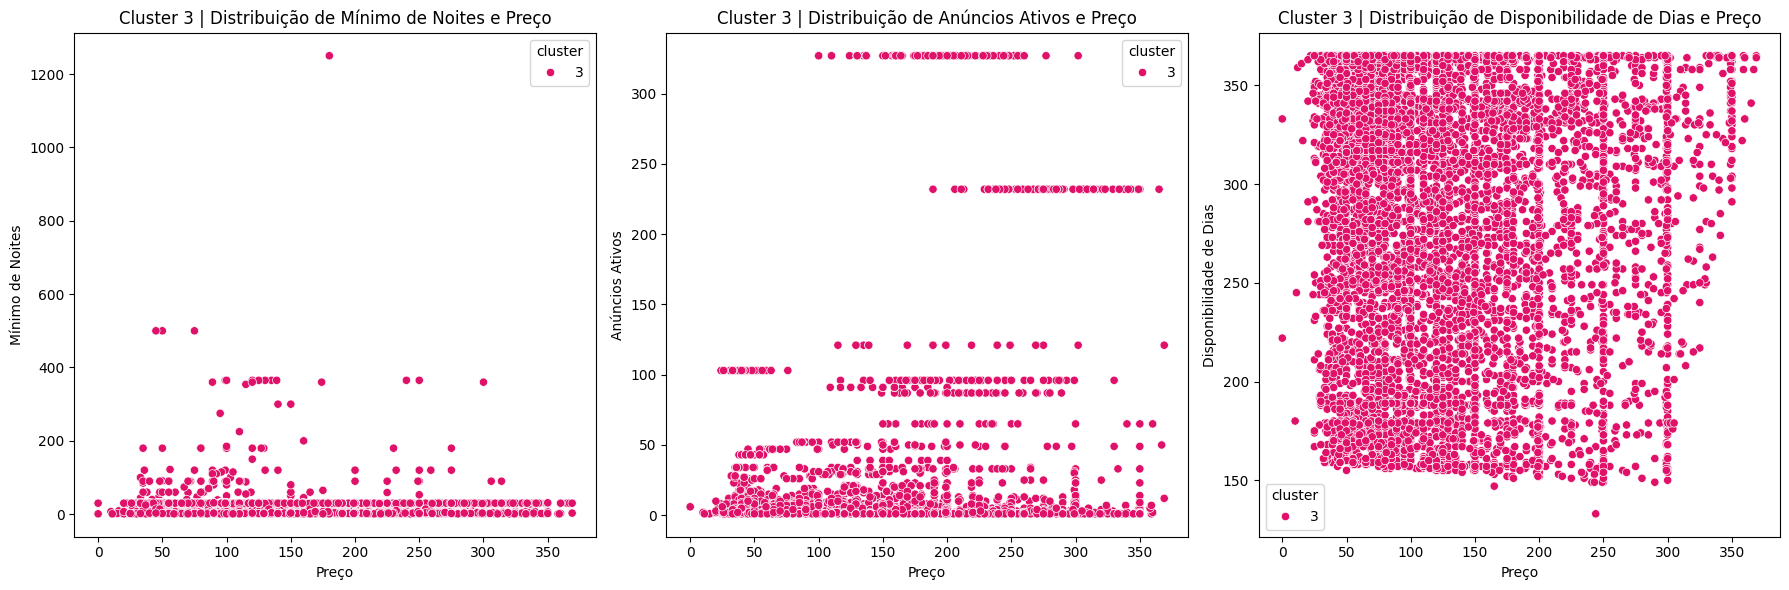

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data.query('cluster == 3'), 
                x="price", y="minimo_noites", 
                hue="cluster", palette=paleta_personalizada, ax=axes[0])
axes[0].set(title='Cluster 3 | Distribuição de Mínimo de Noites e Preço', xlabel='Preço', ylabel='Mínimo de Noites')
axes[0].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 3'), 
                x="price", y="calculado_host_listings_count", 
                hue="cluster", palette=paleta_personalizada, ax=axes[1])
axes[1].set(title='Cluster 3 | Distribuição de Anúncios Ativos e Preço', xlabel='Preço', ylabel='Anúncios Ativos')
axes[1].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 3'), 
                x="price", y="disponibilidade_365", 
                hue="cluster", palette=paleta_personalizada, ax=axes[2])
axes[2].set(title='Cluster 3 | Distribuição de Disponibilidade de Dias e Preço', xlabel='Preço', ylabel='Disponibilidade de Dias')
axes[2].get_legend().set_title("cluster")

plt.tight_layout()
plt.show()

3. **Análise**:
    * **Distribuição de Mínimo de Noites e Preço**: O mínimo de noites varia de 0 a 1.200, enquanto o preço está entre 0 e 350. Há uma quantidade considerável de dados, com uma forte concentração antes das 200 noites e uma boa distribuição de preços. Registros acima de 500 noites são raros.

    * **Distribuição de Anúncios Ativos e Preço**: Os anúncios ativos variam de 0 a 300, enquanto o preço está entre 0 e 350. A maior concentração ocorre para anúncios ativos abaixo de 125, com variação de preços. Pequenas concentrações adicionais aparecem em valores próximos de 240 e 340.

    * **Distribuição de Disponibilidade de Dias e Preço**: A disponibilidade de dias varia de 0 a 350, enquanto o preço oscila entre 0 e 350. A distribuição dos dados é semelhante ao cluster 0, com leve redução na concentração para preços acima de 300.

**Resumo do perfil de dados**: Este cluster possui uma das maiores quantidades de dados, se assemelhando ao cluster 0, com uma ampla variedade de anúncios e preços acessíveis.

* **Cluster 4**:

C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3283665504.py:3: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 4'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3283665504.py:9: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 4'),
C:\Users\micae\AppData\Local\Temp\ipykernel_20280\3283665504.py:15: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=clustered_data.query('cluster == 4'),


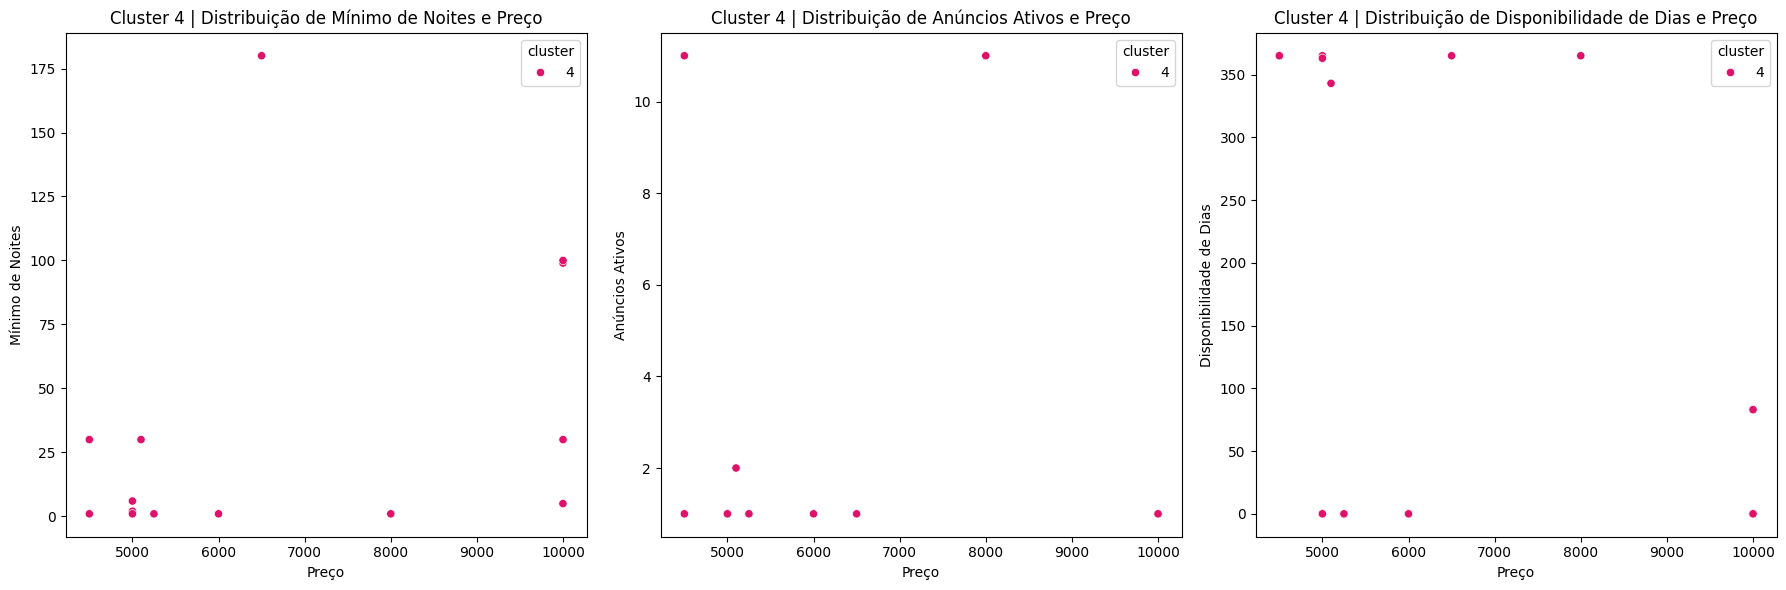

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=clustered_data.query('cluster == 4'), 
                x="price", y="minimo_noites", 
                hue="cluster", palette=paleta_personalizada, ax=axes[0])
axes[0].set(title='Cluster 4 | Distribuição de Mínimo de Noites e Preço', xlabel='Preço', ylabel='Mínimo de Noites')
axes[0].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 4'), 
                x="price", y="calculado_host_listings_count", 
                hue="cluster", palette=paleta_personalizada, ax=axes[1])
axes[1].set(title='Cluster 4 | Distribuição de Anúncios Ativos e Preço', xlabel='Preço', ylabel='Anúncios Ativos')
axes[1].get_legend().set_title("cluster")

sns.scatterplot(data=clustered_data.query('cluster == 4'), 
                x="price", y="disponibilidade_365", 
                hue="cluster", palette=paleta_personalizada, ax=axes[2])
axes[2].set(title='Cluster 4 | Distribuição de Disponibilidade de Dias e Preço', xlabel='Preço', ylabel='Disponibilidade de Dias')
axes[2].get_legend().set_title("cluster")

plt.tight_layout()
plt.show()

4. **Análise**:
    * **Distribuição de Mínimo de Noites e Preço**: O mínimo de noites varia de 0 a 175, enquanto o preço está entre 5.000 e 10.000. A quantidade de dados é extremamente baixa, sendo a maior concentração antes das 30 noites. Há poucos registros ao longo do gráfico.

    * **Distribuição de Anúncios Ativos e Preço**: Os anúncios ativos variam de 0 a 10, enquanto o preço está entre 5.000 e 10.000. A quantidade de dados é extremamente reduzida, com uma pequena concentração para valores de até 2 anúncios ativos e registros esporádicos além disso.

    * **Distribuição de Disponibilidade de Dias e Preço**: A disponibilidade de dias varia de 0 a 350, enquanto o preço está entre 5.000 e 10.000. Há pouquíssimos registros, com concentração apenas em torno de 10 dias e 350 dias.

**Resumo do perfil de dados**: Este cluster representa uma categoria de luxo com altíssimos preços, sendo a mais rara entre todas as categorias analisadas.

### Predição

* **Caso de Exemplo**: Suponhas que o apartamento tenha as seguintes características: 
``` {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

```
 Qual seria a sua sugestão de perfil para esse apartamento?

In [51]:
registro_exemplo = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

In [56]:
registro = np.array([355,2,1,346.20])

Valores equivalentes respectivamente as colunas 'disponibilidade_365', 'calculado_host_listings_count', 'minimo_noites' e 'price' do registro de exemplo. E o preço do melhor método de predição da etapa de regressão.

In [59]:
cluster = model.predict(registro.reshape(1,-1))
print(cluster)

[3]


c:\Users\micae\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


O registro tem preço 346, mínimo de noites 1 e disponibilidade de 355 dias, o que está dentro da faixa do Cluster 3, reforçando que esse grupo contém muitos registros com características semelhantes ao Cluster 0, mas com diferenças sutis na distribuição.

## 6. Insights

### Regressão:

| **Métrica** | **Interpretação** | **DummyRegressor** | **KNeighborsRegressor** | **LinearRegression** | **Análise** |
|------------|-----------------|-------------------|----------------------|--------------------|---------|
| **fit_time (s)** | Tempo médio para treinar o modelo (menor é melhor) | 0.0594 | 0.0592 | 0.0734 | DummyRegressor e KNeighborsRegressor são mais rápidos que LinearRegression. |
| **score_time (s)** | Tempo médio para fazer predições (menor é melhor) | 0.0261 | 5.0373 | 0.0238 | KNeighborsRegressor é muito mais lento, pois calcula distâncias entre pontos. |
| **MAE negativo** | Erro absoluto médio (mais próximo de zero é melhor) | -93.43 | -77.40 | -74.89 | LinearRegression tem o menor erro absoluto, seguido pelo KNeighborsRegressor. |
| **MSE negativo** | Erro quadrático médio (mais próximo de zero é melhor) | -64001.50 | -61533.28 | -58817.08 | LinearRegression tem o menor erro quadrático médio. |
| **MAPE negativo** | Erro percentual absoluto médio (mais próximo de zero é melhor) | -7.02e+13 | -4.37e+13 | -3.73e+13 | Valores extremamente altos indicam que o MAPE pode não ser adequado. |
| **R² (Coeficiente de Determinação)** | Mede a proporção da variância explicada pelo modelo (mais próximo de 1 é melhor) | -0.000347 | 0.0318 | 0.0894 | LinearRegression tem o melhor desempenho, seguido por KNeighborsRegressor. |
| **Predição do Preço ($)** | Preço médio previsto pelo modelo | 152.58 | 346.20 | 276.51 | KNeighborsRegressor sugere o preço mais alto, baseado em vizinhos semelhantes. |
| **Análise final** | Comparação entre modelos | - | - | - | O KNeighborsRegressor é o mais próximo da média de predições (311.36), sendo a melhor escolha. |


* Melhorias:
    * **Feature Engineering**: Incluir mais variáveis e criar variáveis derivadas.
    * **Tratamento de Outliers**: Tratar outliers para evitar distorções.
    * **Testar modelos não lineares**: Testar modelos mais robustos não lineares como XGBoost e LightGBM.

### Classificação:

| **Métrica**              | **Logistic Regression**                                | **KNeighbors Classifier**                          | **Análise** |
|--------------------------|--------------------------------------------------------|--------------------------------------------------|-------------|
| **Acurácia**            | 0.53                                                   | 0.50                                             | A Regressão Logística teve um desempenho ligeiramente melhor. |
| **Classe "Alta"**       | Precision: 0.42 <br> Recall: 0.37 <br> F1-score: 0.39  | Precision: 0.39 <br> Recall: 0.45 <br> F1-score: 0.41 | Ambos os modelos tiveram dificuldades, mas o KNN teve um recall maior, indicando que capturou mais instâncias. |
| **Classe "Baixa"**      | Precision: 0.41 <br> Recall: 0.30 <br> F1-score: 0.34  | Precision: 0.38 <br> Recall: 0.37 <br> F1-score: 0.37 | Ambos tiveram baixo desempenho, indicando dificuldade na previsão dessa classe. |
| **Classe "Muito Alta"** | Precision: 0.56 <br> Recall: 0.65 <br> F1-score: 0.60  | Precision: 0.57 <br> Recall: 0.52 <br> F1-score: 0.54 | A Regressão Logística teve um recall melhor, capturando mais instâncias corretamente. |
| **Classe "Muito Baixa"** | Precision: 0.63 <br> Recall: 0.77 <br> F1-score: 0.69  | Precision: 0.66 <br> Recall: 0.63 <br> F1-score: 0.64 | A Regressão Logística se destacou pelo maior recall. O KNN teve precisão ligeiramente superior. |
| **Macro Avg**          | Precision: 0.51 <br> Recall: 0.52 <br> F1-score: 0.51  | Precision: 0.50 <br> Recall: 0.49 <br> F1-score: 0.49 | A Regressão Logística obteve melhores médias, indicando maior equilíbrio entre as classes. |
| **Weighted Avg**       | Precision: 0.51 <br> Recall: 0.53 <br> F1-score: 0.51  | Precision: 0.50 <br> Recall: 0.50 <br> F1-score: 0.50 | O modelo de Regressão Logística teve um desempenho geral um pouco superior. |
| **Predição Final**     | Classe prevista: **Muito Alta**                        | Classe prevista: **Muito Alta**                  | Ambos os modelos classificaram o apartamento como de alto valor. |
| **Probabilidades**      | **Classe "Alta"**: 18.7% <br> **Classe "Baixa"**: 1.9% <br> **Classe "Muito Alta"**: 79.2% <br> **Classe "Muito Baixa"**: 0.068% | **Classe "Alta"**: 0% <br> **Classe "Baixa"**: 0% <br> **Classe "Muito Alta"**: 100% <br> **Classe "Muito Baixa"**: 0% | O KNN foi mais extremo, prevendo 100% de certeza na classe "Muito Alta", enquanto a Regressão Logística apresentou maior equilíbrio. |


* Melhorias:
    * **Balanceamento das classes**: Aplicar técnicas de balanceamento de classes para evitar distribuição desigual.
    * **Refinar os Limites das Classes**: Refinar limites das categorias de faixa de preço.
    * **Exploração de Modelos mais robustos**: testar modelos mais robustos (Random Forest, SVM).
    * **Inserir mais colunas**: Engenhar novos atributos e realizar feature selection.

### Agrupamento:

| **Cluster** | **Faixa de Preço (USD)** | **Mínimo de Noites** | **Disponibilidade (dias/ano)** | **Perfil** |
|------------|-----------------|-----------------|------------------|---------|
| **0** | 0 - 350 | 0 - 400 (maioria até 50) | Varia de 0 a 160, maioria abaixo de 200 | Grande volume de anúncios, preços acessíveis, estadias curtas, alta disponibilidade. Ideal para turistas e locações curtas. |
| **1** | 1.500 - 4.000 | 0 - 350 (maioria até 50) | Concentração antes de 25 dias e acima de 340 | Mercado premium, poucos anúncios, preços elevados, exigência moderada de noites mínimas. Provável foco em viajantes de luxo. |
| **2** | 400 - 1.400 | 0 - 350 (maioria até 40) | Distribuição ampla, com concentração abaixo de 800 | Quantidade intermediária de dados, faixa de preço moderada, distribuição equilibrada entre disponibilidade e número de anúncios. |
| **3** | 0 - 350 | 0 - 1.200 (maioria até 200) | Varia de 0 a 350, similar ao Cluster 0 | Perfil semelhante ao Cluster 0, mas com maior variação em noites mínimas. Pode incluir imóveis que permitem estadias mais longas. |
| **4** | 5.000 - 10.000 | 0 - 175 (maioria até 30) | Poucos registros, concentrados em 10 ou 350 dias | Categoria de luxo, raridade entre os clusters, imóveis extremamente caros e exclusivos, baixa disponibilidade. |


* Melhorias:
    * **Normalização de dados**: Testar diferentes técnicas de normalização.
    * **Abordagens de Agrupamento**: Explorar novos métodos de clustering como GMM e Agglomerative Clustering.
    * **Número de Clusters**: Determinar o número ideal de clusters com Elbow Method e Silhouette Score.
    * **Novas Features**: ncluir novas features para melhor separação dos grupos.